In [1]:
import os
from pathlib import Path
import pickle
from time import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.network_comparison_utils import *

In [2]:
"""
bp       = '/media/omega/Daten1/CATCH/CS'
bp_annos = '/media/omega/Daten1/CATCH/CS/Preds/FCN'
bp_cases = '/media/omega/Daten1/CATCH/CS/Cases'
bp_imgs  = '/media/omega/Daten1/CATCH/CS/Imgs'
"""
bp       = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases'
bp_annos = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Annos'
bp_cases = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Cases'
bp_imgs  = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Imgs'


In [3]:
# load cases
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'Annos' in p]
cases1 = [pickle.load(open(p, 'rb')) for p in case_paths]
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'UNet' in p and 'MRUNet' not in p]
cases2 = [pickle.load(open(p, 'rb')) for p in case_paths]
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'FCN' in p]
cases3 = [pickle.load(open(p, 'rb')) for p in case_paths]
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'MRUNet' in p]
cases4 = [pickle.load(open(p, 'rb')) for p in case_paths]
cases1 = sorted(cases1, key=lambda c: c.case_name)
cases2 = sorted(cases2, key=lambda c: c.case_name)
cases3 = sorted(cases3, key=lambda c: c.case_name)
cases4 = sorted(cases4, key=lambda c: c.case_name)
names = set([c.case_name for c in cases2])
cases1 = [c for c in cases1 if c.case_name in names]

#cases1 = cases1[:3]
#cases2 = cases2[:3]

In [4]:
print(len(cases1))

3


## Metric Table

In [5]:
metric_names  = ['dice', 'hd', 'ml diff', 'by reader1', 'by reader2', 'position1', 'position2']
contour_names = ['lv_endo', 'lv_myo', 'rv_endo']
ph_names      = ['ES', 'ED']

column_names  = ['case name', 'reader1', 'reader2', 'slice']
column_names += [cn+' '+p+' '+mn for cn in contour_names for p in ph_names for mn in metric_names]
print(len(column_names))
print(column_names)

def get_position(case, d, p, cont_name):
    cat  = case.categories[0]
    anno = cat.get_anno(d, p)
    has_cont = anno.has_contour(cont_name)
    if not has_cont:                    return 'outside'
    if has_cont and d==0:               return 'basal'
    if has_cont and d==cat.nr_slices-1: return 'apical'
    prev_has_cont = cat.get_anno(d-1, p).has_contour(cont_name)
    next_has_cont = cat.get_anno(d+1, p).has_contour(cont_name)
    if prev_has_cont and next_has_cont: return 'midv'
    if prev_has_cont and not next_has_cont: return 'apical'
    if not prev_has_cont and next_has_cont: return 'basal'

    
def metrics_phase_slice_table(cases1, cases2, fixed_phase_first_reader=False):
    dsc, hd, mld = DiceMetric(), HausdorffMetric(), mlDiffMetric()
    metrics = [dsc.get_val, hd.get_val, mld.get_val, lambda g1,g2,_: not g1.is_empty, lambda g1,g2,_: not g2.is_empty]
    view = SAX_CINE_View()
    row_dict = {}
    row_counter = 0
    for c1,c2 in zip(cases1, cases2):
        cc = Case_Comparison(c1,c2)
        nr_slices = c1.categories[0].nr_slices
        for sl_nr in range(nr_slices):
            row = [c1.case_name if sl_nr==0 else '', c1.reader_name, c2.reader_name,  sl_nr]
            for cont in contour_names:
                cat_es1, cat_ed1 = view.get_categories(c1, cont)
                cat_es2, cat_ed2 = view.get_categories(c2, cont)
                p_es1, p_ed1 = cat_es1.phase, cat_ed1.phase 
                p_es2, p_ed2 = (p_es1, p_ed1) if fixed_phase_first_reader else (cat_es2.phase, cat_ed2.phase)
                for cat1, cat2 in zip([cat_es1, cat_ed1],[cat_es2, cat_ed2]):
                    p1, p2 = cat1.phase, cat1.phase if fixed_phase_first_reader else cat2.phase
                    dcm = cat1.get_dcm(sl_nr, p1)
                    cont1, cont2 = cat1.get_anno(sl_nr, p1).get_contour(cont), cat2.get_anno(sl_nr, p2).get_contour(cont)
                    for m in metrics: 
                        if p1 is None or p2 is None: row.append('')
                        else: row.append(m(cont1, cont2, dcm))
                    row.extend([get_position(c1, sl_nr, p1, cont), get_position(c2, sl_nr, p2, cont)])
            row_dict['row_'+str(row_counter).zfill(5)] = row
            row_counter +=1 
    df = pandas.DataFrame.from_dict(row_dict, orient='index', columns=column_names)
    return df
unet_table   = metrics_phase_slice_table(cases1, cases2, fixed_phase_first_reader=True)
fcn_table    = metrics_phase_slice_table(cases1, cases3, fixed_phase_first_reader=True)
mrunet_table = metrics_phase_slice_table(cases1, cases4, fixed_phase_first_reader=True)
display(unet_table)

46
['case name', 'reader1', 'reader2', 'slice', 'lv_endo ES dice', 'lv_endo ES hd', 'lv_endo ES ml diff', 'lv_endo ES by reader1', 'lv_endo ES by reader2', 'lv_endo ES position1', 'lv_endo ES position2', 'lv_endo ED dice', 'lv_endo ED hd', 'lv_endo ED ml diff', 'lv_endo ED by reader1', 'lv_endo ED by reader2', 'lv_endo ED position1', 'lv_endo ED position2', 'lv_myo ES dice', 'lv_myo ES hd', 'lv_myo ES ml diff', 'lv_myo ES by reader1', 'lv_myo ES by reader2', 'lv_myo ES position1', 'lv_myo ES position2', 'lv_myo ED dice', 'lv_myo ED hd', 'lv_myo ED ml diff', 'lv_myo ED by reader1', 'lv_myo ED by reader2', 'lv_myo ED position1', 'lv_myo ED position2', 'rv_endo ES dice', 'rv_endo ES hd', 'rv_endo ES ml diff', 'rv_endo ES by reader1', 'rv_endo ES by reader2', 'rv_endo ES position1', 'rv_endo ES position2', 'rv_endo ED dice', 'rv_endo ED hd', 'rv_endo ED ml diff', 'rv_endo ED by reader1', 'rv_endo ED by reader2', 'rv_endo ED position1', 'rv_endo ED position2']


,case name,reader1,reader2,slice,lv_endo ES dice,lv_endo ES hd,lv_endo ES ml diff,lv_endo ES by reader1,lv_endo ES by reader2,lv_endo ES position1,...,rv_endo ES by reader2,rv_endo ES position1,rv_endo ES position2,rv_endo ED dice,rv_endo ED hd,rv_endo ED ml diff,rv_endo ED by reader1,rv_endo ED by reader2,rv_endo ED position1,rv_endo ED position2
row_00000,ECSPRESS-003,Annos,UNet,0,100.000000,0.000000,0.000000,False,False,outside,...,False,outside,outside,13.025919,15.382394,4.202588,True,True,basal,basal
row_00001,,Annos,UNet,1,100.000000,0.000000,0.000000,False,False,outside,...,False,outside,outside,91.756402,3.952847,0.327148,True,True,midv,midv
row_00002,,Annos,UNet,2,100.000000,0.000000,0.000000,False,False,outside,...,True,outside,basal,81.208953,11.416667,-2.904173,True,True,midv,midv
row_00003,,Annos,UNet,3,93.560239,2.310904,-0.168723,True,True,basal,...,True,basal,midv,97.105688,1.609434,0.296620,True,True,midv,midv
row_00004,,Annos,UNet,4,96.961725,1.006920,0.025775,True,True,midv,...,True,midv,midv,96.344146,1.783411,0.571670,True,True,midv,midv
row_00005,,Annos,UNet,5,92.686068,2.946278,-0.812964,True,True,midv,...,True,midv,midv,95.812639,1.975545,1.118663,True,True,midv,midv
row_00006,,Annos,UNet,6,92.636193,1.765802,-0.452730,True,True,midv,...,True,midv,midv,95.130666,2.083333,0.706941,True,True,midv,midv
row_00007,,Annos,UNet,7,93.534285,2.266912,-0.759099,True,True,midv,...,True,midv,midv,94.019138,4.233629,1.448065,True,True,midv,midv
row_00008,,Annos,UNet,8,95.224930,1.550090,-0.352496,True,True,midv,...,True,midv,midv,95.527460,2.352599,0.704747,True,True,midv,midv
row_00009,,Annos,UNet,9,89.278498,2.359967,-0.782315,True,True,midv,...,True,midv,midv,93.727007,1.666667,0.505863,True,True,midv,midv


In [6]:
def contour_subset(table, cont_name):
    names = [c for c in column_names if cont_name in c]
    ret_table = table.copy()
    ret_table = ret_table[names]
    # sort by phase
    es_names = [c for c in column_names if cont_name in c and 'ES' in c]
    ed_names = [c for c in column_names if cont_name in c and 'ED' in c]
    es_table = ret_table[es_names]
    ed_table = ret_table[ed_names]
    es_table.columns = [n.replace('ES ', '') for n in es_names]
    ed_table.columns = [n.replace('ED ', '') for n in ed_names]
    combined = es_table.append(ed_table)
    return combined

def add_absolute_mldiff(table):
    names = [c for c in table.columns if 'ml diff' in c]
    new_names  = [n.replace('ml diff', 'abs ml diff') for n in names]
    ret_table  = table.copy()
    absmldiffs = np.abs(ret_table[names].values)
    ret_table[new_names] = absmldiffs
    return ret_table

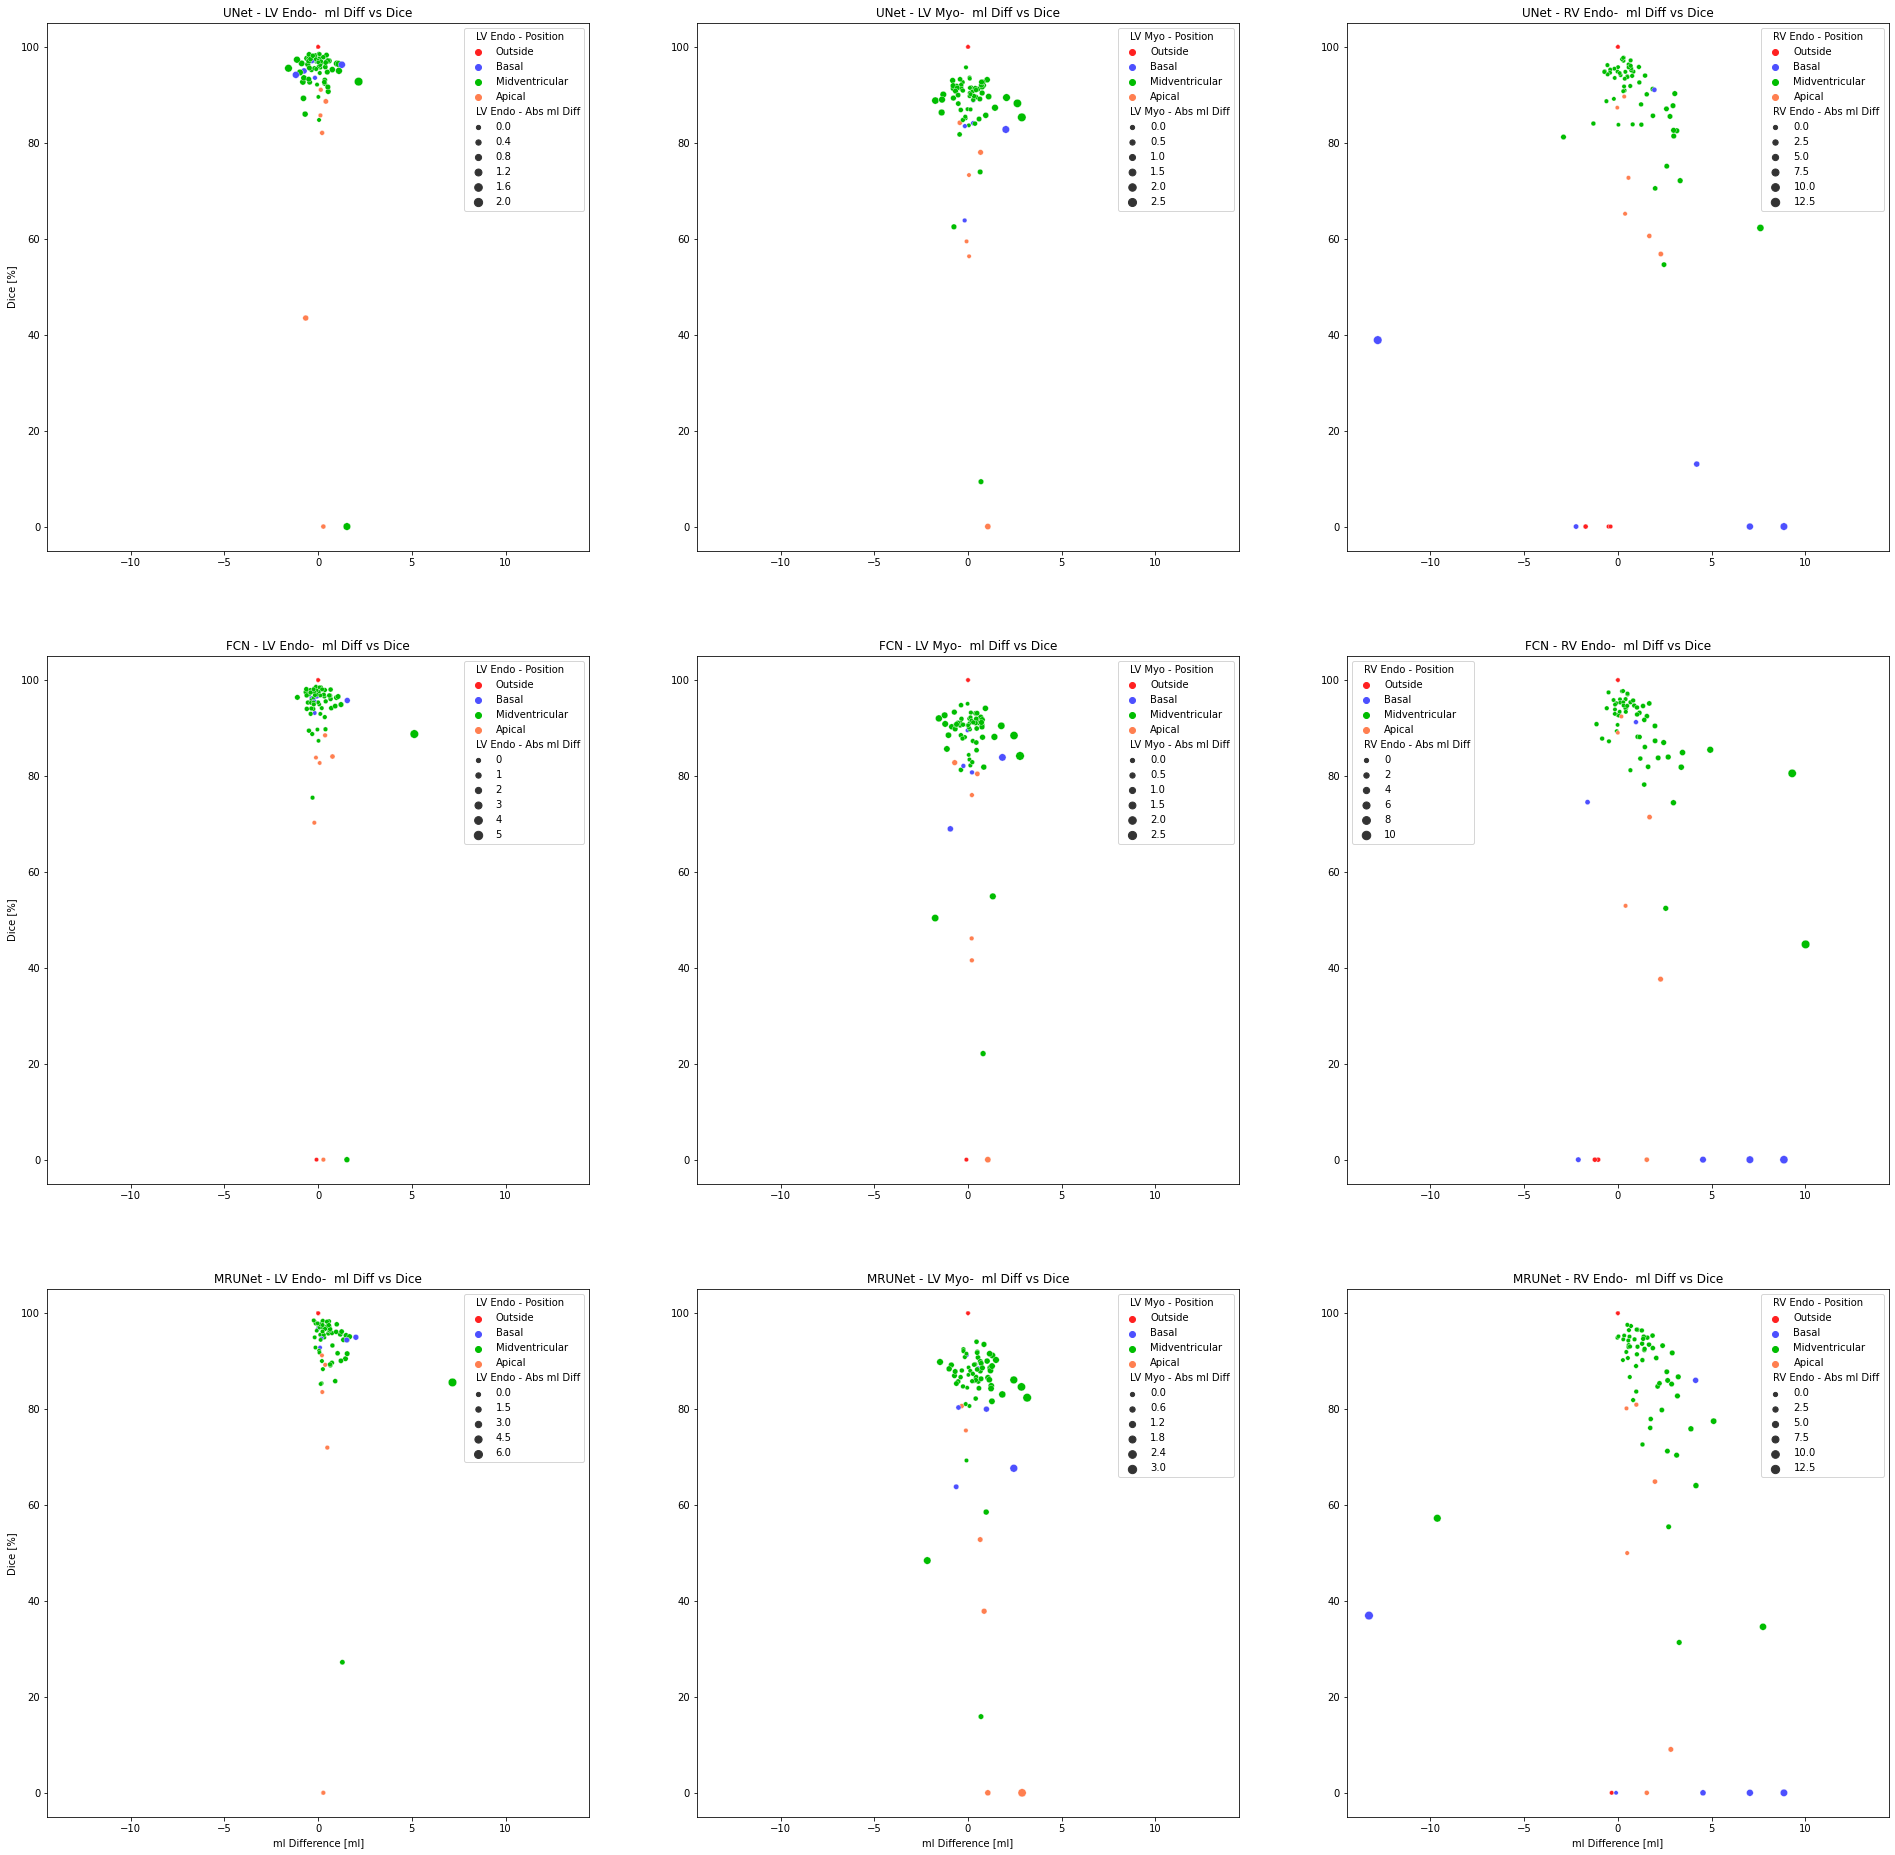

In [21]:
unet_lv_endo_table = add_absolute_mldiff(contour_subset(unet_table, 'lv_endo'))
unet_lv_myo_table  = add_absolute_mldiff(contour_subset(unet_table, 'lv_myo' ))
unet_rv_endo_table = add_absolute_mldiff(contour_subset(unet_table, 'rv_endo'))

fcn_lv_endo_table = add_absolute_mldiff(contour_subset(fcn_table, 'lv_endo'))
fcn_lv_myo_table  = add_absolute_mldiff(contour_subset(fcn_table, 'lv_myo' ))
fcn_rv_endo_table = add_absolute_mldiff(contour_subset(fcn_table, 'rv_endo'))

mrunet_lv_endo_table = add_absolute_mldiff(contour_subset(mrunet_table, 'lv_endo'))
mrunet_lv_myo_table  = add_absolute_mldiff(contour_subset(mrunet_table, 'lv_myo' ))
mrunet_rv_endo_table = add_absolute_mldiff(contour_subset(mrunet_table, 'rv_endo'))

colors = ["#FF2020", "#4d57ff", "#208020", "#FF7F50"]# Set your custom color palette
colors = ["#FF2020", "#4d50ff", "#00bd00", "#FF7F50"]# Set your custom color palette
custom_palette = sns.set_palette(sns.color_palette(colors))

fig, axes = plt.subplots(3,3,figsize=(33,33), sharex=True, sharey=True)
for i in range(3): 
    for j in range(3): 
        axes[i][j].set_title(['UNet', 'FCN', 'MRUNet'][i] +' - '+ ['LV Endo', 'LV Myo', 'RV Endo'][j] + '-  ml Diff vs Dice')
sns.scatterplot(ax=axes[0,0], data=unet_lv_endo_table, x='lv_endo ml diff', y='lv_endo dice', 
                size='lv_endo abs ml diff', hue='lv_endo position1', picker=4, palette=custom_palette)
sns.scatterplot(ax=axes[0,1], data=unet_lv_myo_table, x='lv_myo ml diff', y='lv_myo dice', 
                size='lv_myo abs ml diff', hue='lv_myo position1', picker=4, palette=custom_palette)
sns.scatterplot(ax=axes[0,2], data=unet_rv_endo_table, x='rv_endo ml diff', y='rv_endo dice', 
                size='rv_endo abs ml diff', hue='rv_endo position1', picker=4, palette=custom_palette)

sns.scatterplot(ax=axes[1,0], data=fcn_lv_endo_table, x='lv_endo ml diff', y='lv_endo dice', 
                size='lv_endo abs ml diff', hue='lv_endo position1', picker=4, palette=custom_palette)
sns.scatterplot(ax=axes[1,1], data=fcn_lv_myo_table, x='lv_myo ml diff', y='lv_myo dice', 
                size='lv_myo abs ml diff', hue='lv_myo position1', picker=4, palette=custom_palette)
sns.scatterplot(ax=axes[1,2], data=fcn_rv_endo_table, x='rv_endo ml diff', y='rv_endo dice', 
                size='rv_endo abs ml diff', hue='rv_endo position1', picker=4, palette=custom_palette)

sns.scatterplot(ax=axes[2,0], data=mrunet_lv_endo_table, x='lv_endo ml diff', y='lv_endo dice', 
                size='lv_endo abs ml diff', hue='lv_endo position1', picker=4, palette=custom_palette)
sns.scatterplot(ax=axes[2,1], data=mrunet_lv_myo_table, x='lv_myo ml diff', y='lv_myo dice', 
                size='lv_myo abs ml diff', hue='lv_myo position1', picker=4, palette=custom_palette)
sns.scatterplot(ax=axes[2,2], data=mrunet_rv_endo_table, x='rv_endo ml diff', y='rv_endo dice', 
                size='rv_endo abs ml diff', hue='rv_endo position1', picker=4, palette=custom_palette)

xabs_max = 0
for i in range(3):
    for j in range(3):
        xabs_max = abs(max(axes[i][j].get_xlim(), key=abs))

for i in range(3):
    for j in range(3):
        axes[i][j].xaxis.set_tick_params(which='both', labelbottom=True)
        axes[i][j].yaxis.set_tick_params(which='both', labelbottom=True)
        axes[i][j].set_ylabel('Dice [%]')
        axes[i][j].set_xlabel('ml Difference [ml]')
        axes[i][j].xaxis.set_tick_params(which='both', labelbottom=True)
        axes[i][j].xaxis.set_tick_params(which='both', labelbottom=True)
        axes[i][j].set_xlim(-xabs_max, xabs_max)
        leg = axes[i][j].axes.get_legend()
        cont_name_ = ['LV Endo', 'LV Myo', 'RV Endo'][j]
        for t, l in zip(leg.texts, [cont_name_+' - Position', 'Outside', 'Basal', 'Midventricular', 'Apical', cont_name_+' - Abs ml Diff']):
            t.set_text(l)

#fig.tight_layout()
plt.show()

In [23]:
def add_cont_type_column(table, cont_type):
    ret_table = table.copy()
    table_len = len(ret_table)
    ret_table['cont_type'] = [cont_type for _ in range(table_len)]
    ret_table.columns = [n.replace(cont_type,'').strip() for n in ret_table.columns]
    return ret_table

def plottable_per_network(table):
    lv_endo_table = add_absolute_mldiff(add_cont_type_column(contour_subset(table, 'lv_endo'), 'lv_endo'))
    lv_myo_table  = add_absolute_mldiff(add_cont_type_column(contour_subset(table, 'lv_myo' ), 'lv_myo' ))
    rv_endo_table = add_absolute_mldiff(add_cont_type_column(contour_subset(table, 'rv_endo'), 'rv_endo'))
    tables = [lv_endo_table, lv_myo_table, rv_endo_table]
    ret_table = pd.concat(tables)
    return ret_table

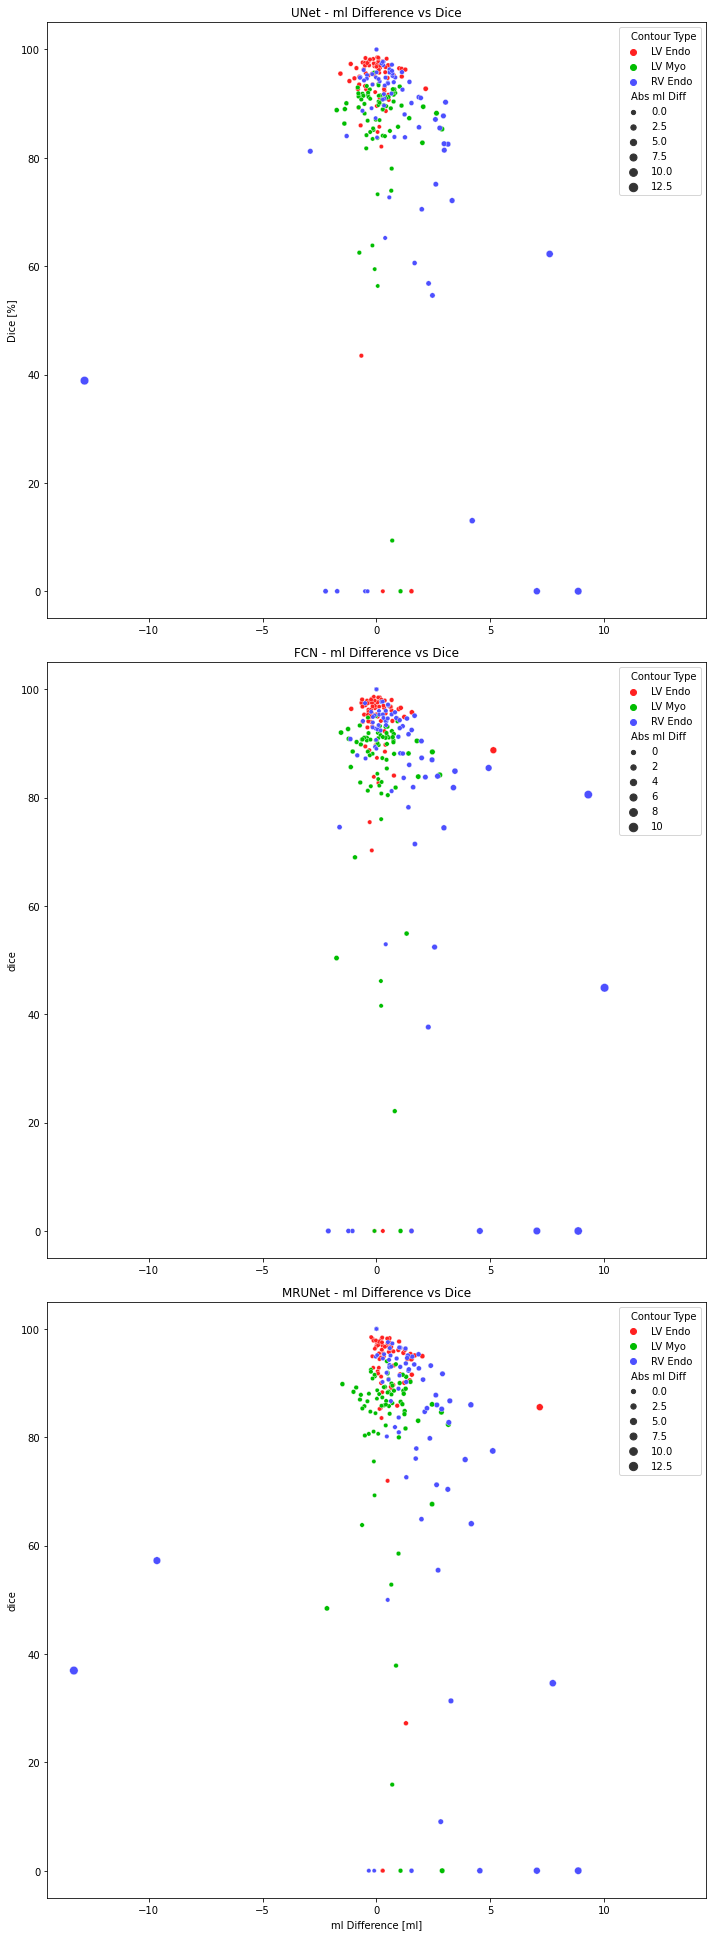

In [33]:
unet_plottable   = plottable_per_network(unet_table)
fcn_plottable    = plottable_per_network(fcn_table)
mrunet_plottable = plottable_per_network(mrunet_table)

colors = ["#FF2020", "#208020", "#2020FF"]# Set your custom color palette
colors = ["#FF2020", "#00bd00", "#4d50ff"]# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

fig, axes = plt.subplots(3,1,figsize=(10,27), sharex=True, sharey=True)
for i in range(3): 
    axes[i].set_title(['UNet', 'FCN', 'MRUNet'][i] + ' - ml Difference vs Dice')
sns.scatterplot(ax=axes[0], data=unet_plottable, x='ml diff', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4, palette=customPalette)
sns.scatterplot(ax=axes[1], data=fcn_plottable, x='ml diff', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4, palette=customPalette)
sns.scatterplot(ax=axes[2], data=mrunet_plottable, x='ml diff', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4, palette=customPalette)
axes[0].set_ylabel('Dice [%]')
axes[2].set_xlabel('ml Difference [ml]')
axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[1].xaxis.set_tick_params(which='both', labelbottom=True)

x_max = 0
for ax in axes:
    x_max = abs(max(ax.get_xlim(), key=abs))

for i in range(3):
    axes[i].set_xlim(-x_max,x_max)
    leg = axes[i].axes.get_legend()
    for t, l in zip(leg.texts, ['Contour Type', 'LV Endo', 'LV Myo', 'RV Endo', 'Abs ml Diff']):
        t.set_text(l)

fig.tight_layout()
plt.show()

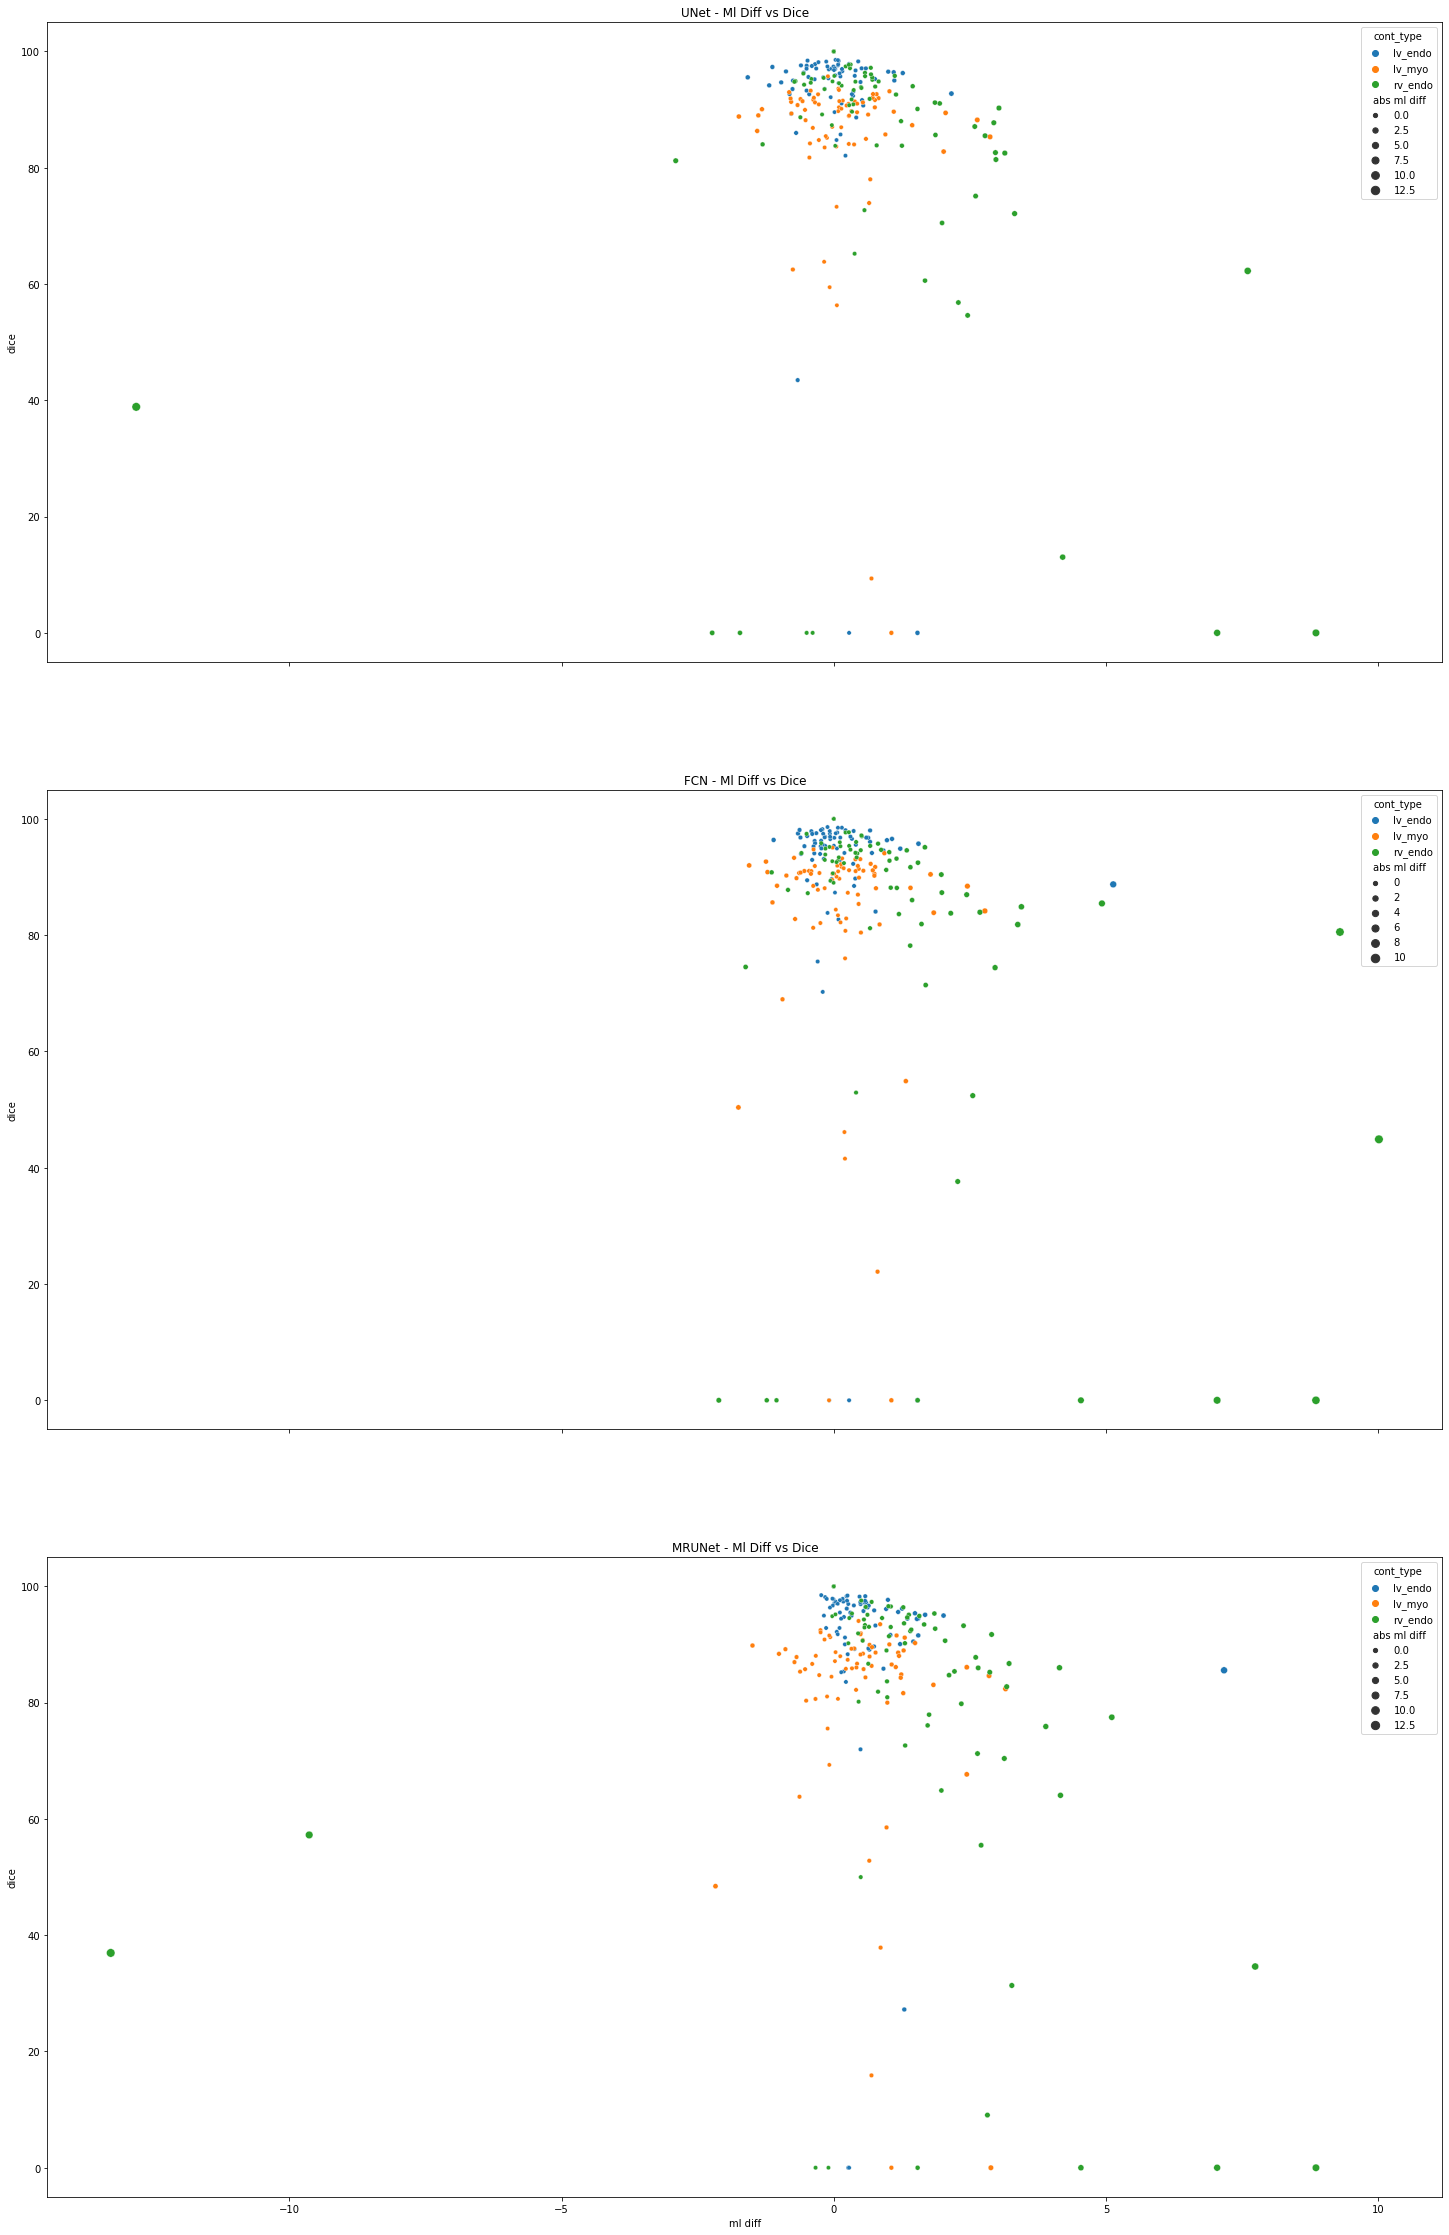

In [76]:
unet_plottable   = plottable_per_network(unet_table)
fcn_plottable    = plottable_per_network(fcn_table)
mrunet_plottable = plottable_per_network(mrunet_table)

fig, axes = plt.subplots(3,1,figsize=(25,40), sharex=True)
for i in range(3): 
    axes[i].set_title(['UNet', 'FCN', 'MRUNet'][i] + ' - Ml Diff vs Dice')
sns.scatterplot(ax=axes[0], data=unet_plottable, x='ml diff', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4)
sns.scatterplot(ax=axes[1], data=fcn_plottable, x='ml diff', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4)
sns.scatterplot(ax=axes[2], data=mrunet_plottable, x='ml diff', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4)
plt.show()

In [9]:
def contour_subset(table, cont_name):
    ret_table = table.copy()
    return ret_table[ret_table['contour name']==cont_name]

def several_contour_subset(table, cont_names):
    ret_table = table.copy()
    return ret_table[ret_table['contour name'].isin(cont_names)]

def dice_subset_segmentation_failures(table, low_value=0, high_value=80.0):
    ret_table = table.copy()
    ret_table = ret_table[ret_table['DSC']<high_value]
    ret_table = ret_table[low_value < ret_table['DSC']]
    return ret_table

def hd_subset_segmentation_failures(table, value=2.0):
    ret_table = table.copy()
    return ret_table[ret_table['HD']>value]

def absmldiff_subset_segmentation_failures(table, value=2.0):
    ret_table = table.copy()
    return ret_table[ret_table['abs ml diff']>value]

def add_normalized_values(table):
    ret_table = table.copy()
    names = ['DSC', 'HD', 'ml diff', 'abs ml diff']
    data = ret_table[names].values.astype(np.float64)
    print('In add normalized values:')
    print('Length of data: ', data.shape)
    data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    ret_table[[n+' normalized' for n in names]] = pd.DataFrame(data).values
    return ret_table

def add_pca_whitened_values(table):
    ret_table = table.copy()
    #names = ['DSC', 'HD', 'ml diff', 'abs ml diff']
    names = ['DSC', 'HD', 'ml diff', 'depth_perc']
    data = ret_table[names].values.astype(np.float64)
    pca = PCA(whiten=True)
    whitened = pca.fit_transform(data)
    ret_table[['pca_whitened_'+str(n_i) for n_i in range(len(names))]] = pd.DataFrame(whitened).values
    return ret_table

In [6]:
# Get myocardium subset
#table = contour_subset(table, 'lv_myo')
#table = several_contour_subset(table, ['rv_endo', 'lv_endo', 'lv_myo'])
table = several_contour_subset(table, ['lv_myo'])

# Get segmentation failures
#print('All myos: ', len(table))
table = dice_subset_segmentation_failures(table, low_value=0, high_value=90.0)
#print('Poor myos: ', len(table))

# Normalize this data
table = add_normalized_values(table)
table = add_pca_whitened_values(table)
print('New table columns: ', table.columns)

In add normalized values:
Length of data:  (46, 4)
New table columns:  Index(['case', 'reader1', 'reader2', 'sop1', 'sop2', 'category', 'slice',
       'max_slices', 'depth_perc', 'phase1', 'phase2', 'contour name', 'DSC',
       'HD', 'ml diff', 'abs ml diff', 'position1', 'position2',
       'has_contour1', 'has_contour2', 'DSC normalized', 'HD normalized',
       'ml diff normalized', 'abs ml diff normalized', 'pca_whitened_0',
       'pca_whitened_1', 'pca_whitened_2', 'pca_whitened_3'],
      dtype='object')


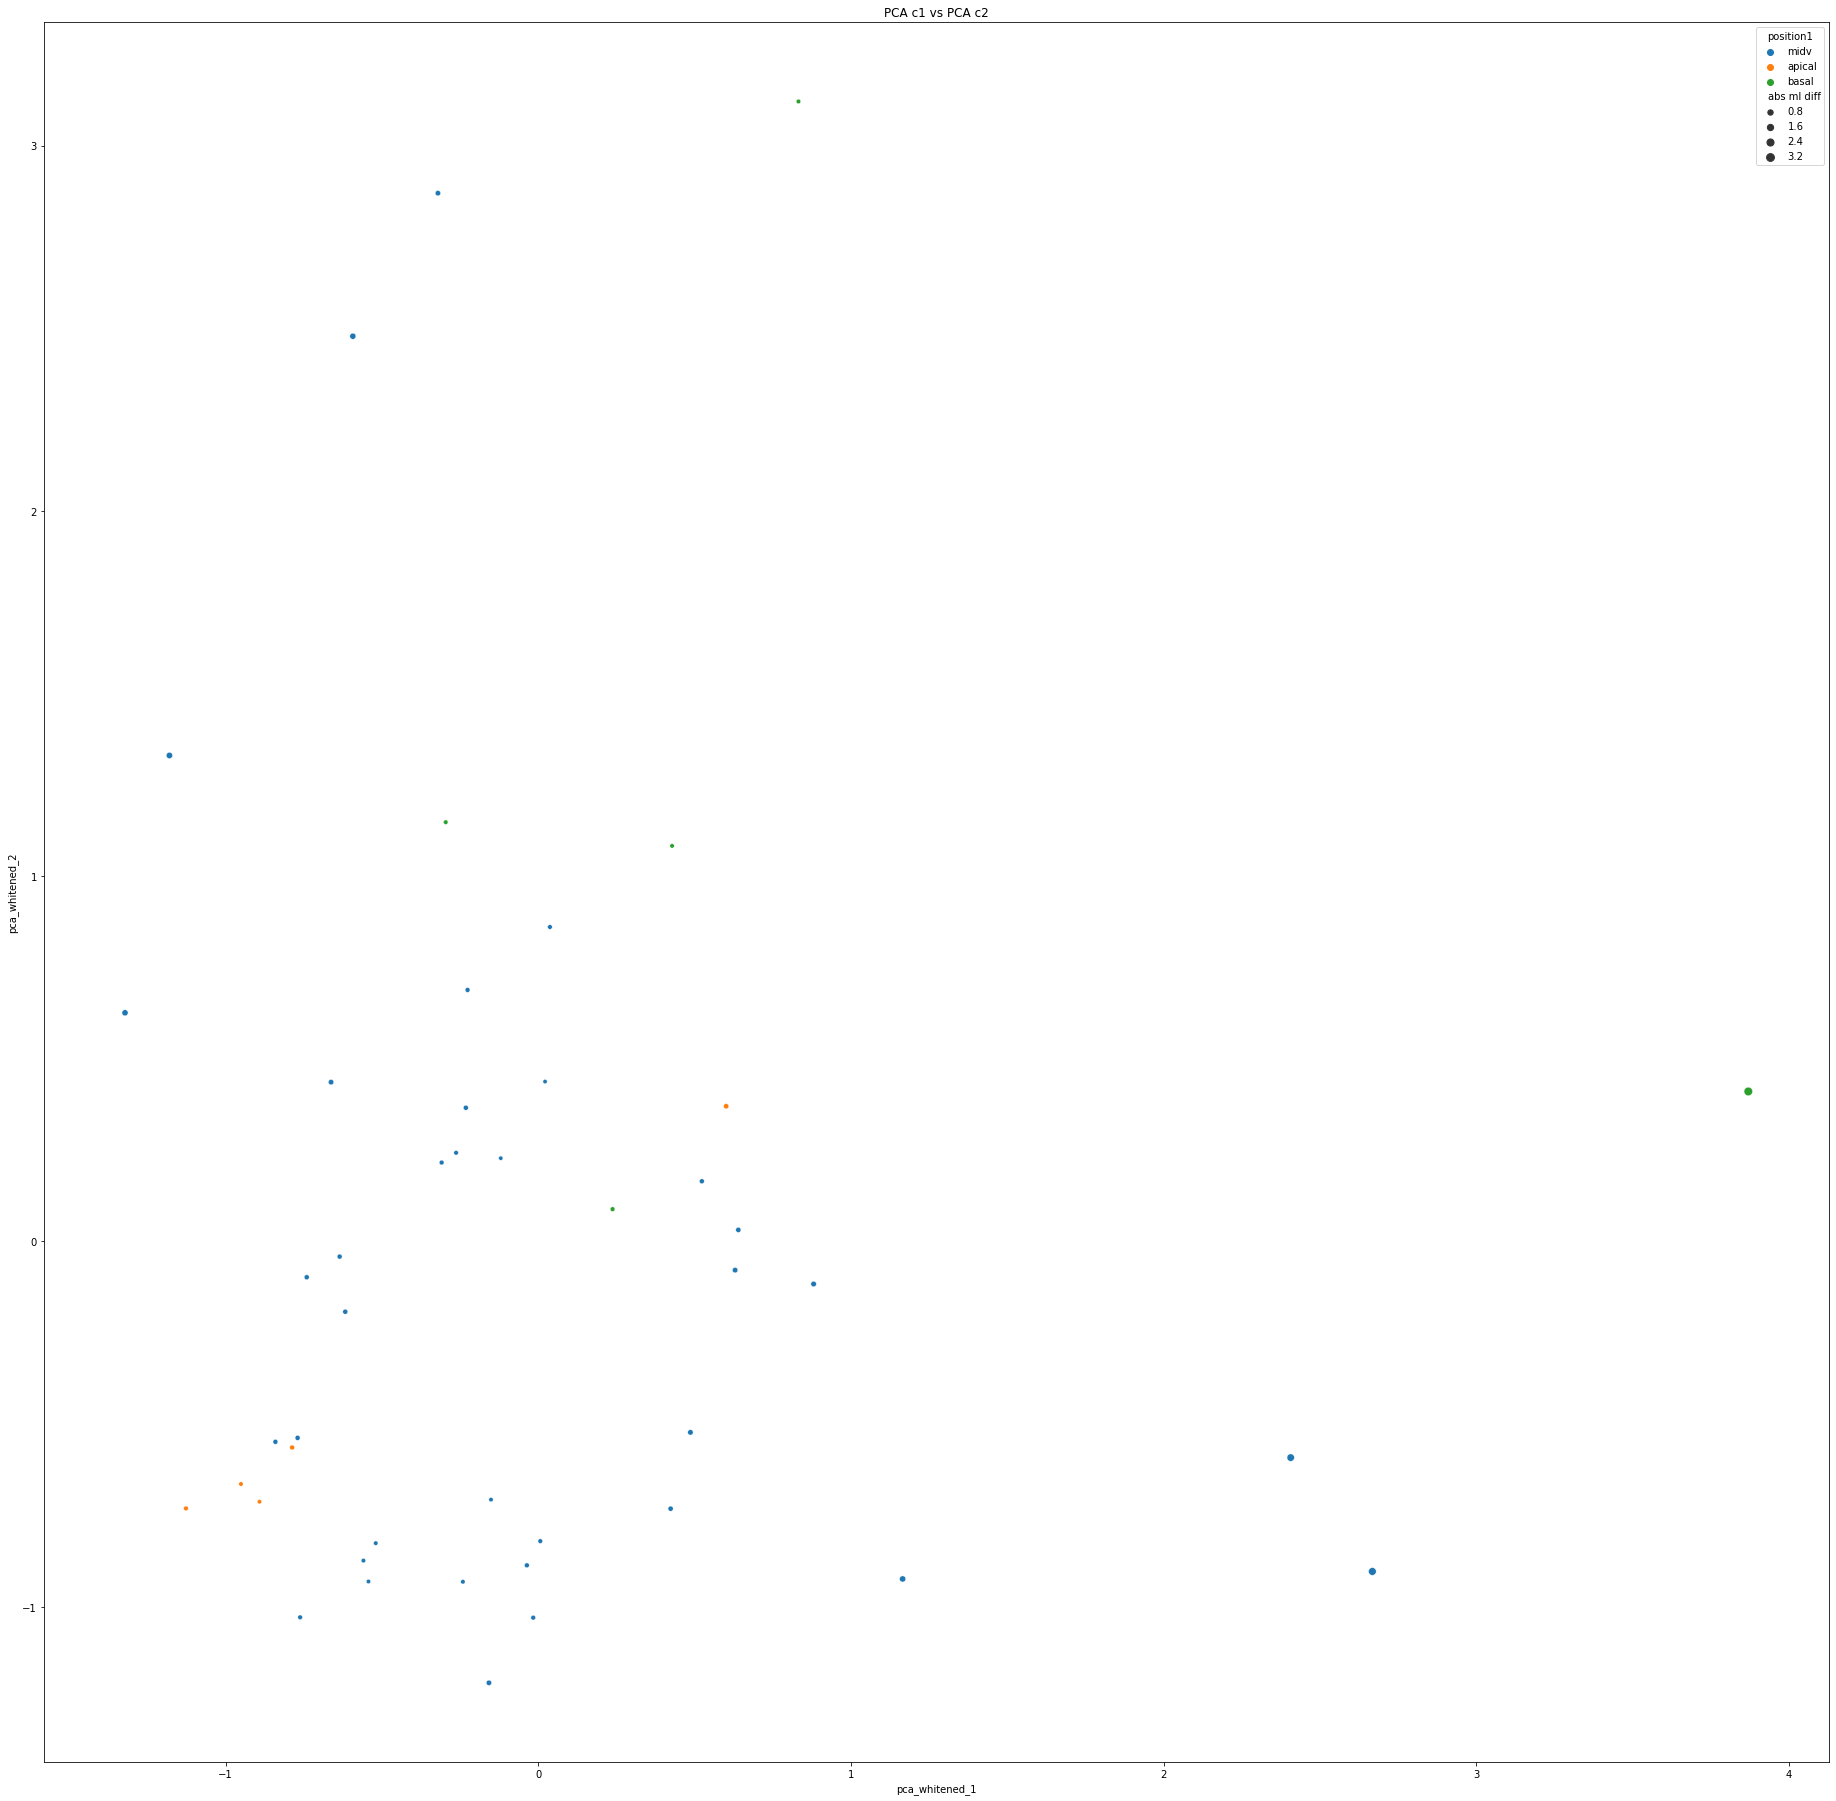

In [7]:
fig, axes = plt.subplots(1,1,figsize=(32,32))
axes.set_title('PCA c1 vs PCA c2')
sns.scatterplot(ax=axes, data=table, x='pca_whitened_1', y='pca_whitened_2', 
                size='abs ml diff', hue='position1', picker=4)

def onpick(event):
    ind = event.ind
    print('onpick: ', ind)
    case_name  = table.iloc[ind]['case'].values[0]
    phase      = table.iloc[ind]['category'].values[0]
    reader1    = table.iloc[ind]['reader1'].values[0]
    reader2    = table.iloc[ind]['reader2'].values[0]
    slice_nr   = table.iloc[ind]['slice'].values[0]
    cont_name  = table.iloc[ind]['contour name'].values[0]
    sop1, sop2 = table.iloc[ind]['sop1'].values[0], table.iloc[ind]['sop2'].values[0]
    
    cc     = [cc for cc in case_comps if cc.case1.case_name==case_name][0]
    c1, c2 = cc.case1, cc.case2
    img    = c1.load_dcm(sop1).pixel_array
    cont1, cont2 = c1.load_anno(sop1).get_contour(cont_name), c2.load_anno(sop2).get_contour(cont_name)
    
    fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
    fig.suptitle(case_name + ', Phase: ' + str(phase) + ', Slice: ' + str(slice_nr))
    for i in range(3): ax[i].imshow(img, cmap='gray'); ax[i].axis('off')
    ax[0].set_title(reader1); ax[2].set_title(reader2)
    if not cont1.is_empty: CATCH_utils.plot_outlines(ax[0], cont1); 
    if not cont2.is_empty: CATCH_utils.plot_outlines(ax[2], cont2)
    if not cont1.is_empty and not cont2.is_empty: CATCH_utils.plot_geo_face_comparison(ax[1], cont1, cont2)
    fig.tight_layout()
    plt.show()
    
fig.canvas.mpl_connect('pick_event', onpick)
plt.show()

<ipython-input-86-f091a174efc6>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_table['phase'] = 'es'
<ipython-input-86-f091a174efc6>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_table['cont_type'] = cont_name
<ipython-input-86-f091a174efc6>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,case name,reader1,reader2,slice,lv_endo ES dice,lv_endo ES hd,lv_endo ES ml diff,lv_endo ES by reader1,lv_endo ES by reader2,lv_endo ES position1,...,rv_endo ES by reader2,rv_endo ES position1,rv_endo ES position2,rv_endo ED dice,rv_endo ED hd,rv_endo ED ml diff,rv_endo ED by reader1,rv_endo ED by reader2,rv_endo ED position1,rv_endo ED position2
row_00000,ECSPRESS-003,Annos,UNet,0,100.000000,0.000000,0.000000,False,False,outside,...,False,outside,outside,13.025919,15.382394,4.202588,True,True,basal,basal
row_00001,ECSPRESS-003,Annos,UNet,1,100.000000,0.000000,0.000000,False,False,outside,...,False,outside,outside,91.756402,3.952847,0.327148,True,True,midv,midv
row_00002,ECSPRESS-003,Annos,UNet,2,100.000000,0.000000,0.000000,False,False,outside,...,True,outside,basal,81.208953,11.416667,-2.904173,True,True,midv,midv
row_00003,ECSPRESS-003,Annos,UNet,3,93.560239,2.310904,-0.168723,True,True,basal,...,True,basal,midv,97.105688,1.609434,0.296620,True,True,midv,midv
row_00004,ECSPRESS-003,Annos,UNet,4,96.961725,1.006920,0.025775,True,True,midv,...,True,midv,midv,96.344146,1.783411,0.571670,True,True,midv,midv
row_00005,ECSPRESS-003,Annos,UNet,5,92.686068,2.946278,-0.812964,True,True,midv,...,True,midv,midv,95.812639,1.975545,1.118663,True,True,midv,midv
row_00006,ECSPRESS-003,Annos,UNet,6,92.636193,1.765802,-0.452730,True,True,midv,...,True,midv,midv,95.130666,2.083333,0.706941,True,True,midv,midv
row_00007,ECSPRESS-003,Annos,UNet,7,93.534285,2.266912,-0.759099,True,True,midv,...,True,midv,midv,94.019138,4.233629,1.448065,True,True,midv,midv
row_00008,ECSPRESS-003,Annos,UNet,8,95.224930,1.550090,-0.352496,True,True,midv,...,True,midv,midv,95.527460,2.352599,0.704747,True,True,midv,midv
row_00009,ECSPRESS-003,Annos,UNet,9,89.278498,2.359967,-0.782315,True,True,midv,...,True,midv,midv,93.727007,1.666667,0.505863,True,True,midv,midv


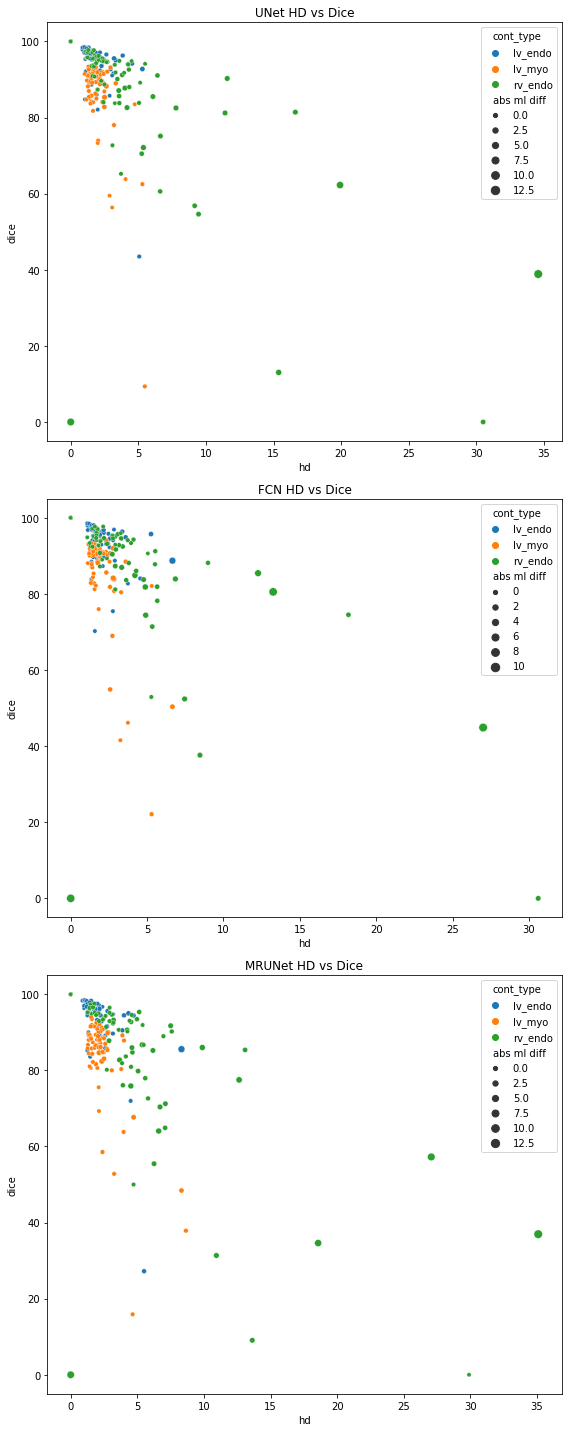

In [86]:
import os
from pathlib import Path
import pickle
from time import time
import pandas as pd

import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Polygon
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.network_comparison_utils import *


"""
bp       = '/media/omega/Daten1/CATCH/CS'
bp_annos = '/media/omega/Daten1/CATCH/CS/Preds/FCN'
bp_cases = '/media/omega/Daten1/CATCH/CS/Cases'
bp_imgs  = '/media/omega/Daten1/CATCH/CS/Imgs'
"""
bp       = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases'
bp_annos = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Annos'
bp_cases = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Cases'
bp_imgs  = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Imgs'


# load cases
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'Annos' in p]
cases1 = [pickle.load(open(p, 'rb')) for p in case_paths]
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'UNet' in p and 'MRUNet' not in p]
cases2 = [pickle.load(open(p, 'rb')) for p in case_paths]
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'FCN' in p]
cases3 = [pickle.load(open(p, 'rb')) for p in case_paths]
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'MRUNet' in p]
cases4 = [pickle.load(open(p, 'rb')) for p in case_paths]
cases1 = sorted(cases1, key=lambda c: c.case_name)
cases2 = sorted(cases2, key=lambda c: c.case_name)
cases3 = sorted(cases3, key=lambda c: c.case_name)
cases4 = sorted(cases4, key=lambda c: c.case_name)
names = set([c.case_name for c in cases2])
cases1 = [c for c in cases1 if c.case_name in names]

#cases1 = cases1[:3]
#cases2 = cases2[:3]


metric_names  = ['dice', 'hd', 'ml diff', 'by reader1', 'by reader2', 'position1', 'position2']
contour_names = ['lv_endo', 'lv_myo', 'rv_endo']
ph_names      = ['ES', 'ED']

column_names  = ['case name', 'reader1', 'reader2', 'slice']
column_names += [cn+' '+p+' '+mn for cn in contour_names for p in ph_names for mn in metric_names]

def get_position(case, d, p, cont_name):
    cat  = case.categories[0]
    anno = cat.get_anno(d, p)
    has_cont = anno.has_contour(cont_name)
    if not has_cont:                    return 'outside'
    if has_cont and d==0:               return 'basal'
    if has_cont and d==cat.nr_slices-1: return 'apical'
    prev_has_cont = cat.get_anno(d-1, p).has_contour(cont_name)
    next_has_cont = cat.get_anno(d+1, p).has_contour(cont_name)
    if prev_has_cont and next_has_cont: return 'midv'
    if prev_has_cont and not next_has_cont: return 'apical'
    if not prev_has_cont and next_has_cont: return 'basal'

    
def metrics_phase_slice_table(cases1, cases2, fixed_phase_first_reader=False):
    dsc, hd, mld = DiceMetric(), HausdorffMetric(), mlDiffMetric()
    metrics = [dsc.get_val, hd.get_val, mld.get_val, lambda g1,g2,_: not g1.is_empty, lambda g1,g2,_: not g2.is_empty]
    view = SAX_CINE_View()
    row_dict = {}
    row_counter = 0
    for c1,c2 in zip(cases1, cases2):
        cc = Case_Comparison(c1,c2)
        nr_slices = c1.categories[0].nr_slices
        for sl_nr in range(nr_slices):
            row = [c1.case_name, c1.reader_name, c2.reader_name,  sl_nr]
            for cont in contour_names:
                cat_es1, cat_ed1 = view.get_categories(c1, cont)
                cat_es2, cat_ed2 = view.get_categories(c2, cont)
                p_es1, p_ed1 = cat_es1.phase, cat_ed1.phase 
                p_es2, p_ed2 = (p_es1, p_ed1) if fixed_phase_first_reader else (cat_es2.phase, cat_ed2.phase)
                for cat1, cat2 in zip([cat_es1, cat_ed1],[cat_es2, cat_ed2]):
                    p1, p2 = cat1.phase, cat1.phase if fixed_phase_first_reader else cat2.phase
                    dcm = cat1.get_dcm(sl_nr, p1)
                    cont1, cont2 = cat1.get_anno(sl_nr, p1).get_contour(cont), cat2.get_anno(sl_nr, p2).get_contour(cont)
                    for m in metrics: 
                        if p1 is None or p2 is None: row.append('')
                        else: row.append(m(cont1, cont2, dcm))
                    row.extend([get_position(c1, sl_nr, p1, cont), get_position(c2, sl_nr, p2, cont)])
            row_dict['row_'+str(row_counter).zfill(5)] = row
            row_counter +=1 
    df = pandas.DataFrame.from_dict(row_dict, orient='index', columns=column_names)
    return df

unet_table   = metrics_phase_slice_table(cases1, cases2, fixed_phase_first_reader=True)
fcn_table    = metrics_phase_slice_table(cases1, cases3, fixed_phase_first_reader=True)
mrunet_table = metrics_phase_slice_table(cases1, cases4, fixed_phase_first_reader=True)


def contour_subset(table, cont_name):
    names = column_names[:4] + [c for c in column_names if cont_name in c]
    ret_table = table.copy()
    ret_table = ret_table[names]
    # sort by phase
    es_names = column_names[:4] + [c for c in column_names if cont_name in c and 'ES' in c]
    ed_names = column_names[:4] + [c for c in column_names if cont_name in c and 'ED' in c]

    es_table = ret_table[es_names]
    #es_table = pd.concat([es_table, pd.DataFrame([['es', cont_name] for _ in range(len(es_table))], columns=['phase', 'cont_type'])], axis=1)
    es_table['phase'] = 'es'
    es_table['cont_type'] = cont_name
    
    ed_table = ret_table[ed_names]
    #ed_table = pd.concat([ed_table, pd.DataFrame([['ed', cont_name] for _ in range(len(ed_table))], columns=['phase', 'cont_type'])], axis=1)
    ed_table['phase'] = 'ed'
    ed_table['cont_type'] = cont_name
    
    es_table.columns = [n.replace('ES ', '') for n in es_table.columns]
    ed_table.columns = [n.replace('ED ', '') for n in ed_table.columns]
    combined = es_table.append(ed_table)
    return combined

def add_absolute_mldiff(table):
    names = [c for c in table.columns if 'ml diff' in c]
    new_names  = [n.replace('ml diff', 'abs ml diff') for n in names]
    ret_table  = table.copy()
    absmldiffs = np.abs(ret_table[names].values)
    ret_table[new_names] = absmldiffs
    return ret_table


def add_cont_type_column(table, cont_type):
    ret_table = table.copy()
    table_len = len(ret_table)
    ret_table['cont_type'] = [cont_type for _ in range(table_len)]
    ret_table.columns = [n.replace(cont_type,'').strip() for n in ret_table.columns]
    return ret_table

def plottable_per_network(table):
    lv_endo_table = add_absolute_mldiff(add_cont_type_column(contour_subset(table, 'lv_endo'), 'lv_endo'))
    lv_myo_table  = add_absolute_mldiff(add_cont_type_column(contour_subset(table, 'lv_myo' ), 'lv_myo' ))
    rv_endo_table = add_absolute_mldiff(add_cont_type_column(contour_subset(table, 'rv_endo'), 'rv_endo'))
    tables = [lv_endo_table, lv_myo_table, rv_endo_table]
    ret_table = pd.concat(tables)
    return ret_table

unet_plottable   = plottable_per_network(unet_table)
fcn_plottable    = plottable_per_network(fcn_table)
mrunet_plottable = plottable_per_network(mrunet_table)

#display(unet_plottable)

fig, axes = plt.subplots(3,1,figsize=(8,20))
for i in range(3): 
    axes[i].set_title(['UNet', 'FCN', 'MRUNet'][i] + ' HD vs Dice')
sns.scatterplot(ax=axes[0], data=unet_plottable, x='hd', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4)
sns.scatterplot(ax=axes[1], data=fcn_plottable, x='hd', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4)
sns.scatterplot(ax=axes[2], data=mrunet_plottable, x='hd', y='dice', 
                size='abs ml diff', hue='cont_type', picker=4)

display(unet_table)

def onpick(event):
    ind = event.ind
    print('onpick: ', ind)
    table = unet_table
    c1s, c2s = cases1, cases2
    
    case_name  = table.iloc[ind]['case name'].values[0]
    phase      = table.iloc[ind]['phase'].values[0]
    reader1    = table.iloc[ind]['reader1'].values[0]
    reader2    = table.iloc[ind]['reader2'].values[0]
    slice_nr   = table.iloc[ind]['slice'].values[0]
    cont_type  = table.iloc[ind]['cont_type'].values[0]
    
    c1, c2 = [c for c in c1s if c.case_name==case_name][0], [c for c in c2s if c.case_name==case_name][0]
    cat1, cat2 = [cat for cat in c1.categories if phase in cat.name.lower()][0], [cat for cat in c2.categories if phase in cat.name.lower()][0]
    img   = cat1.get_img(slice_nr, cat1.phase)
    cont1 = cat1.get_anno(slice_nr, cat1.phase).get_contour(cont_type)
    cont2 = cat2.get_anno(slice_nr, cat1.phase).get_contour(cont_type)
    
    fig, ax = plt.subplots(1,1)
    fig.suptitle(case_name + ', Phase: ' + str(phase) + ', Slice: ' + str(slice_nr))
    ax.imshow(img, cmap='gray'); ax.axis('off')
    if not cont1.is_empty and not cont2.is_empty: CATCH_utils.plot_geo_face_comparison(ax, cont1, cont2)
    pst = Polygon([[0,0],[1,1],[1,0]])
    patches = [PolygonPatch(pst,facecolor='red', edgecolor='red',  alpha=0.4),
               PolygonPatch(pst,facecolor='green',edgecolor='green', alpha=0.4),
               PolygonPatch(pst,facecolor='blue',  edgecolor='blue',   alpha=0.4)]
    handles = [reader1,reader1+' & '+reader2,reader2]
    ax.legend(patches, handles)
    fig.tight_layout()
    plt.show()
    
    
fig.canvas.mpl_connect('pick_event', onpick)
fig.tight_layout()
plt.show()



